## GARCH Model

### Description:

In this notebook we will implement the code for a **GARCH Model** in order to make Financial **Time Series Forecasting**.

Most of the notebook will be the same as in the **ARIMA** notebook, since the pre-process the the series must have is quite similar.

As explained in the **SeriesAnalysis** notebook, this notebook will use the results already obtained in **Series Analysis**, so that the focus can be only on the Model itself.

### GARCH Model Brief Introduction

## COMPLETE

In [26]:
### Some useful functions
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model

### Some useful functions


In [2]:
#Read and filter data from csv files, as well as handle missing values
def read_filter(path,index,value):
    df = pd.read_csv(path)
    series = df.loc[:,[index,value]]
    series.set_index(index,inplace=True)
    series.index=pd.to_datetime(series.index)
    series = series.asfreq('d')
    series = series.interpolate()
    return series

#Ploting a single time series
def plot_series(serie,title,xlabel,ylabel):
    plt.figure()
    plt.plot(serie)
    plt.title=title
    plt.xlabel=xlabel
    plt.ylabel=ylabel
    plt.show()
    
    
# differentiate the series
def diff(series,t):
    for i in range(t):
        series = series - series.shift(1)
        series = series.dropna()
    
    return series

#train test split
def train_test(serie,numtest):
    train = serie.iloc[0:len(serie)-numtest]
    test = serie.iloc[len(serie)-numtest:]    
    return train, test
    
#Compute some error metrics
def errors(actual, predicted):
    mape = np.mean(np.abs(predicted - actual)/np.abs(actual))  # MAPE
    me = np.mean(predicted - actual)             # ME
    mae = np.mean(np.abs(predicted - actual))    # MAE
    mpe = np.mean((predicted - actual)/actual)   # MPE
    rmse = np.mean((predicted - actual)**2)**.5  # RMSE
    
    errors = [['MAPE',mape],['ME',me],['MAE',mae],['MPE',mpe],['RMSE',rmse]]
    
    errors = pd.DataFrame(errors,columns=['Error','Value'])
    return errors

#Read and filter data from csv files, as well as handle missing values
def read_filter(path,index,value):
    df = pd.read_csv(path)
    series = df.loc[:,[index,value]]
    series.set_index(index,inplace=True)
    series.index=pd.to_datetime(series.index)
    series = series.asfreq('d')
    series = series.interpolate()
    return series

#Ploting a single time series
def plot_series(serie,title,xlabel,ylabel):
    plt.figure()
    plt.plot(serie)
    plt.title=title
    plt.xlabel=xlabel
    plt.ylabel=ylabel
    plt.show()
    
    
# differentiate the series
def diff(series,t):
    for i in range(t):
        series = series - series.shift(1)
        series = series.dropna()
    
    return series

#train test split
def train_test(serie,numtest):
    train = serie.iloc[0:len(serie)-numtest]
    test = serie.iloc[len(serie)-numtest:]    
    return train, test
    
#Compute some error metrics
def errors(actual, predicted):
    mape = np.mean(np.abs(predicted - actual)/np.abs(actual))  # MAPE
    me = np.mean(predicted - actual)             # ME
    mae = np.mean(np.abs(predicted - actual))    # MAE
    mpe = np.mean((predicted - actual)/actual)   # MPE
    rmse = np.mean((predicted - actual)**2)**.5  # RMSE
    
    errors = [['MAPE',mape],['ME',me],['MAE',mae],['MPE',mpe],['RMSE',rmse]]
    
    errors = pd.DataFrame(errors,columns=['Error','Value'])
    return errors



In [3]:
#Importing the dataset and making some changes
USD_CAD_serie = read_filter('../data/CAD=X.csv','Date','Adj Close')
USD_BRL_serie = read_filter('../data/BRL=X.csv','Date','Adj Close')
AmericanAirlines_serie = read_filter('../data/AAL2010_2019.csv','Date','Adj Close')

#differentiating the series
USD_CAD_serie_diff1 = diff(USD_CAD_serie,1)
USD_BRL_serie_diff2 = diff(USD_BRL_serie,2)
AmericanAirlines_serie_diff1 = diff(AmericanAirlines_serie,1)

## Train and Test Split

In [4]:
train_American_diff1, test_American_diff1 = train_test(AmericanAirlines_serie_diff1,365)
train_USD_CAD_diff1, test_USD_CAD_diff1 = train_test(USD_CAD_serie_diff1,365)
train_USD_BRL_diff2, test_USD_BRL_diff2 = train_test(USD_BRL_serie_diff2,365)

## Fit ARIMA+GARCH Model

In [27]:
arima_American_diff1 = ARIMA(train_American_diff1,order=(1,0,1)).fit()
arima_USD_CAD_diff1 = ARIMA(train_USD_CAD_diff1,order=(1,0,1)).fit()
arima_USD_BRL_diff2 = ARIMA(train_USD_BRL_diff2,order=(1,0,1)).fit()

garch_American_diff1 = arch_model(arima_American_diff1.resid, vol='Garch', p=1, o=0, q=1, dist='Normal').fit()
garch_USD_CAD_diff1 = arch_model(arima_USD_CAD_diff1.resid, vol='Garch', p=1, o=0, q=1, dist='Normal').fit()
garch_USD_BRL_diff2 = arch_model(arima_USD_BRL_diff2.resid, vol='Garch', p=1, o=0, q=1, dist='Normal').fit()

C:\Users\matno\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\matno\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Iteration:      1,   Func. Count:      6,   Neg. LLF: 431716.72831168777
Iteration:      2,   Func. Count:     16,   Neg. LLF: 5635.6897322311825
Iteration:      3,   Func. Count:     22,   Neg. LLF: 229902.29323673257
Iteration:      4,   Func. Count:     31,   Neg. LLF: 4423.742284485548
Iteration:      5,   Func. Count:     37,   Neg. LLF: 62098799.72614311
Iteration:      6,   Func. Count:     47,   Neg. LLF: 12328763.297617963
Iteration:      7,   Func. Count:     57,   Neg. LLF: 667583.1018485108
Iteration:      8,   Func. Count:     66,   Neg. LLF: 2205.2852717093724
Iteration:      9,   Func. Count:     72,   Neg. LLF: 14622.109078999852
Iteration:     10,   Func. Count:     80,   Neg. LLF: 13885.479448434122
Iteration:     11,   Func. Count:     88,   Neg. LLF: 2012.5147805989009
Iteration:     12,   Func. Count:     93,   Neg. LLF: 4502.131220736655
Iteration:     13,   Func. Count:     99,   Neg. LLF: 4587.001222243835
Iteration:     14,   Func. Count:    105,   Neg. LLF: 10

C:\Users\matno\miniconda3\lib\site-packages\arch\univariate\base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 2.002e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\matno\miniconda3\lib\site-packages\arch\univariate\base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\matno\miniconda3\lib\site-packages\arch\univariate\base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005828. Parameter
estimation work better when this value is between 1 and 1000.

## Forecasting


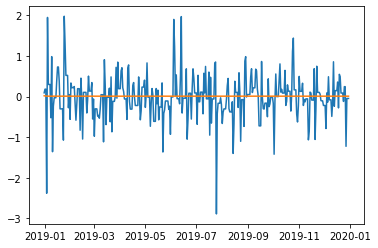

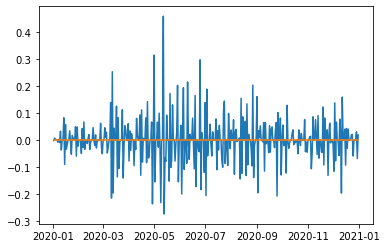

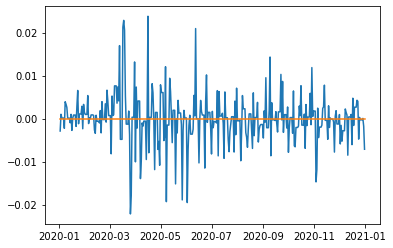

In [80]:
arima_for_American = arima_American_diff1.predict(start=test_American_diff1.index.astype(str)[0],end=test_American_diff1.index.astype(str)[-1])
arima_for_BRL = arima_USD_BRL_diff2.predict(start=test_USD_BRL_diff2.index.astype(str)[0],end=test_USD_BRL_diff2.index.astype(str)[-1])
arima_for_CAD = arima_USD_CAD_diff1.predict(start=test_USD_CAD_diff1.index.astype(str)[0],end=test_USD_CAD_diff1.index.astype(str)[-1])

garch_for_American = garch_American_diff1.forecast(horizon=365)
garch_for_BRL = garch_USD_BRL_diff2.forecast(horizon=365)
garch_for_CAD = garch_USD_CAD_diff1.forecast(horizon=365)

for_American = arima_for_American.copy(deep=True)
for_BRL = arima_for_BRL.copy(deep=True)
for_CAD = arima_for_CAD.copy(deep=True)

for i in range(365):
    for_American[i] += garch_for_American.mean.iloc[-1][i]
    for_BRL = garch_for_BRL.mean.iloc[-1][i]
    for_CAD = garch_for_CAD.mean.iloc[-1][i]

comp_for_American = test_American_diff1.copy(deep=True)
comp_for_BRL = test_USD_BRL_diff2.copy(deep=True)
comp_for_CAD = test_USD_CAD_diff1.copy(deep=True)

comp_for_American['Forecast'] =for_American
comp_for_BRL['Forecast'] = for_BRL
comp_for_CAD['Forecast'] = for_CAD


plt.figure()
plt.plot(comp_for_American)
plt.figure()
plt.plot(comp_for_BRL)
plt.figure()
plt.plot(comp_for_CAD);

In [81]:
for_errors_American_diff1 = errors(comp_for_American['Adj Close'],comp_for_American['Forecast'])
for_errors_USD_CAD_diff1 = errors(comp_for_CAD['Adj Close'],comp_for_CAD['Forecast'])
for_errors_USD_BRL_diff2 = errors(comp_for_BRL['Adj Close'],comp_for_BRL['Forecast'])

print('American')
print(for_errors_American_diff1)
print('USD/BRL')
print(for_errors_USD_BRL_diff2)
print('USD/CAD')
print(for_errors_USD_CAD_diff1)

American
  Error     Value
0  MAPE       inf
1    ME  0.018723
2   MAE  0.356431
3   MPE       inf
4  RMSE  0.527292
USD/BRL
  Error     Value
0  MAPE       inf
1    ME  0.000767
2   MAE  0.050751
3   MPE       inf
4  RMSE  0.081237
USD/CAD
  Error     Value
0  MAPE  0.999983
1    ME  0.000069
2   MAE  0.003511
3   MPE -0.999983
4  RMSE  0.005533
